# Modelo de Score

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
base = pd.read_excel("credito.xlsx")

In [3]:
base.head()

,ID_CREDIT,Moras,Mora_Max,Viajes,CURRENCY_TYPE,LTV_RANGE,INFONAVITSUPP_RANGE2,APPRAISALVALUE_PESOS_RANGE,TYPE_OF_ECONOMY_EN,CREDITDATE,Clasificación Real
0,1,0,0,0,Pesos,80.01-85,No_product,M&R,Formal,2006,0
1,2,0,0,0,Pesos,80.01-85,No_product,M&R,Formal,2006,0
2,3,0,0,0,Pesos,80.01-85,No_product,M&R,Self Employed,2006,0
3,4,0,0,0,Pesos,85.01-90,No_product,M&R,Formal,2007,0
4,5,0,0,0,Pesos,85.01-90,No_product,M&R,Formal,2006,0


La variable dependiente es Clasificación (0 = cliente bueno, 1 = cliente con mora o incumplimiento), y las variables explicativas son:

- ID_CREDIT: Identificador del Crédito
- Moras:	Número de mora
- Mora_Max:	Mora máxima
- Viajes:	Número de viajes
- CURRENCY_TYPE:	Moneda del Crédito
- LTV_RANGE:	Loan to Value
- INFONAVITSUPP_RANGE2:	Producto Infonavit
- APPRAISALVALUE_PESOS_RANGE:	Valor de tasación
- TYPE_OF_ECONOMY_EN:	Tipo de Empleo
- CREDITDATE:	Fecha de otorgamiento del crédito

In [4]:
base.isnull().sum()

ID_CREDIT                     0
Moras                         0
Mora_Max                      0
Viajes                        0
CURRENCY_TYPE                 0
LTV_RANGE                     0
INFONAVITSUPP_RANGE2          0
APPRAISALVALUE_PESOS_RANGE    0
TYPE_OF_ECONOMY_EN            0
CREDITDATE                    0
Clasificación Real            0
dtype: int64

In [5]:
base.isna().sum()

ID_CREDIT                     0
Moras                         0
Mora_Max                      0
Viajes                        0
CURRENCY_TYPE                 0
LTV_RANGE                     0
INFONAVITSUPP_RANGE2          0
APPRAISALVALUE_PESOS_RANGE    0
TYPE_OF_ECONOMY_EN            0
CREDITDATE                    0
Clasificación Real            0
dtype: int64

In [6]:
base.describe()

,ID_CREDIT,Moras,Mora_Max,Viajes,CREDITDATE,Clasificación Real
count,18362.000000,18362.000000,18362.000000,18362.000000,18362.000000,18362.000000
mean,9181.500000,0.375123,6.254221,0.068674,2008.635770,0.019333
std,5300.797157,1.406726,30.952919,0.405318,1.408464,0.137698
min,1.000000,0.000000,0.000000,0.000000,1995.000000,0.000000
25%,4591.250000,0.000000,0.000000,0.000000,2008.000000,0.000000
50%,9181.500000,0.000000,0.000000,0.000000,2009.000000,0.000000
75%,13771.750000,0.000000,0.000000,0.000000,2010.000000,0.000000
max,18362.000000,11.000000,990.000000,7.000000,2010.000000,1.000000


In [7]:
base.columns

Index(['ID_CREDIT', 'Moras', 'Mora_Max', 'Viajes', 'CURRENCY_TYPE',
       'LTV_RANGE', 'INFONAVITSUPP_RANGE2', 'APPRAISALVALUE_PESOS_RANGE',
       'TYPE_OF_ECONOMY_EN', 'CREDITDATE', 'Clasificación Real'],
      dtype='object')

## Weight of Evidence

Técnica para transformar variables categóricas en numéricas basada en la relación entre buenos y malos deudores

Se calcularon los WoE para las variables categóricas:

- Mora_Max: Agrupada en categorías (0, 30, 60, 90+).

- CURRENCY_TYPE: Pesos, Salarios Mínimos, UDIS.

- TYPE_OF_ECONOMY_EN: Formal, Informal, Self Employed.

$$
Weight \ of \ Evidence = ln( \dfrac{Distribution \ Good}{Distribution \ Bad})
$$

In [8]:
MoraM = pd.crosstab(base['Mora_Max'], base['Clasificación Real'], margins=True, margins_name='Total')
MoraM

Clasificación Real,0,1,Total
Mora_Max,,,
0,16252,179,16431
30,1225,61,1286
60,284,32,316
90,103,28,131
120,34,25,59
150,28,11,39
180,14,1,15
210,10,4,14
240,13,2,15


In [9]:
MoraM.iloc[3] = MoraM.iloc[3:-1].sum()
MoraM = MoraM.drop(MoraM.index[4:-1])
MoraM

Clasificación Real,0,1,Total
Mora_Max,,,
0,16252,179,16431
30,1225,61,1286
60,284,32,316
90,246,83,329
Total,18007,355,18362


In [10]:
TotalB = MoraM.loc['Total', 0]
TotalM = MoraM.loc['Total', 1]

MoraM['DBuenos'] = MoraM[0] / TotalB
MoraM['DMalos'] = MoraM[1] / TotalM

MoraM['WoE'] = np.log(MoraM['DBuenos'] / MoraM['DMalos'])

print(MoraM)

Clasificación Real      0    1  Total   DBuenos    DMalos       WoE
Mora_Max                                                           
0                   16252  179  16431  0.902538  0.504225  0.582187
30                   1225   61   1286  0.068029  0.171831 -0.926576
60                    284   32    316  0.015772  0.090141 -1.743160
90                    246   83    329  0.013661  0.233803 -2.839907
Total               18007  355  18362  1.000000  1.000000  0.000000


A mayor mora, mayor probabilidad de incumplimiento

In [11]:
Currency = pd.crosstab(base['CURRENCY_TYPE'], base['Clasificación Real'], margins=True, margins_name='Total')
Currency

Clasificación Real,0,1,Total
CURRENCY_TYPE,,,
Pesos,12816,177,12993
Salarios Minimos,5180,177,5357
UDIS,11,1,12
Total,18007,355,18362


In [12]:
TotalB = Currency.loc['Total', 0]
TotalM = Currency.loc['Total', 1]

Currency['DBuenos'] = Currency[0] / TotalB
Currency['DMalos'] = Currency[1] / TotalM

Currency['WoE'] = np.log(Currency['DBuenos'] / Currency['DMalos'])

Currency

Clasificación Real,0,1,Total,DBuenos,DMalos,WoE
CURRENCY_TYPE,,,,,,
Pesos,12816,177,12993,0.711723,0.498592,0.355902
Salarios Minimos,5180,177,5357,0.287666,0.498592,-0.549987
UDIS,11,1,12,0.000611,0.002817,-1.528503
Total,18007,355,18362,1.000000,1.000000,0.000000


In [13]:
Economía = pd.crosstab(base['TYPE_OF_ECONOMY_EN'], base['Clasificación Real'], margins=True, margins_name='Total')
Economía

Clasificación Real,0,1,Total
TYPE_OF_ECONOMY_EN,,,
Formal,12762,201,12963
Informal,3156,97,3253
Self Employed,2089,57,2146
Total,18007,355,18362


In [14]:
TotalB = Economía.loc['Total', 0]
TotalM = Economía.loc['Total', 1]

Economía['DBuenos'] = Economía[0] / TotalB
Economía['DMalos'] = Economía[1] / TotalM

Economía['WoE'] = np.log(Economía['DBuenos'] / Economía['DMalos'])

Economía

Clasificación Real,0,1,Total,DBuenos,DMalos,WoE
TYPE_OF_ECONOMY_EN,,,,,,
Formal,12762,201,12963,0.708724,0.566197,0.224524
Informal,3156,97,3253,0.175265,0.273239,-0.444048
Self Employed,2089,57,2146,0.116010,0.160563,-0.325009
Total,18007,355,18362,1.000000,1.000000,0.000000


## Base cambiada

In [15]:
Base = pd.DataFrame(columns = ['MoraM', 'Moneda', 'Economía', 'Clasificación'])

dicc_woe = MoraM['WoE'].to_dict()
Base['MoraM'] = base['Mora_Max'].map(dicc_woe)
Base['MoraM'] = Base['MoraM'].fillna(MoraM.loc[90, 'WoE'])

dicc_woe = Currency['WoE'].to_dict()
Base['Moneda'] = base['CURRENCY_TYPE'].map(dicc_woe)

dicc_woe = Economía['WoE'].to_dict()
Base['Economía'] = base['TYPE_OF_ECONOMY_EN'].map(dicc_woe)

Base['Clasificación'] = base['Clasificación Real']

Base

,MoraM,Moneda,Economía,Clasificación
0,0.582187,0.355902,0.224524,0
1,0.582187,0.355902,0.224524,0
2,0.582187,0.355902,-0.325009,0
3,0.582187,0.355902,0.224524,0
4,0.582187,0.355902,0.224524,0
...,...,...,...,...
18357,0.582187,-0.549987,0.224524,0
18358,-1.743160,-0.549987,0.224524,0
18359,0.582187,-0.549987,0.224524,0
18360,0.582187,-0.549987,0.224524,0


In [16]:
X = Base[['MoraM', 'Moneda', 'Economía']]
Y = Base['Clasificación']

X = sm.add_constant(X) 
modelo = sm.Logit(Y, X)
modelo = modelo.fit()

modelo.summary()

Optimization terminated successfully.
         Current function value: 0.081318
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Clasificación   No. Observations:                18362
Model:                          Logit   Df Residuals:                    18358
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 Oct 2025   Pseudo R-squ.:                  0.1479
Time:                        18:47:11   Log-Likelihood:                -1493.2
converged:                       True   LL-Null:                       -1752.3
Covariance Type:            nonrobust   LLR p-value:                4.949e-112
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9270      0.061    -64.572      0.000      -4.046      -3.808
MoraM         -0.9701      0.042    -23.343      0.000      -1.052      -0.889
Moneda        -0.7944      0.123     -6.456      0.000      -1.036      -0.553
Economía      -0.6048      0.181     -3.346      0.001      -0.959      -0.250
==============================================================================
"""

El modelo converge correctamente, lo que indica una estimación estable.

El Pseudo $R^2$ = 0.148 muestra un poder explicativo moderado (en modelos Logit esto es aceptable).

El p-valor del test de razón de verosimilitudes (LLR) es muy pequeño (<0.001), por lo que el conjunto de variables es globalmente significativo: el modelo explica mejor que uno sin predictores.

Todas las variables son significativas (p < 0.05)

In [17]:
Const = round(modelo.params[0], 5)
MM = round(modelo.params[1], 5)
Mon = round(modelo.params[2], 5)
Eco = round(modelo.params[3], 5)

Base['Score'] = Const + (Base['MoraM'] * MM)  + (Base['Moneda'] * Mon) + (Base['Economía'] * Eco)
Base['PD'] = modelo.predict()
Base

,MoraM,Moneda,Economía,Clasificación,Score,PD
0,0.582187,0.355902,0.224524,0,-4.910284,0.007316
1,0.582187,0.355902,0.224524,0,-4.910284,0.007316
2,0.582187,0.355902,-0.325009,0,-4.577938,0.010171
3,0.582187,0.355902,0.224524,0,-4.910284,0.007316
4,0.582187,0.355902,0.224524,0,-4.910284,0.007316
...,...,...,...,...,...,...
18357,0.582187,-0.549987,0.224524,0,-4.190628,0.014911
18358,-1.743160,-0.549987,0.224524,0,-1.934925,0.126207
18359,0.582187,-0.549987,0.224524,0,-4.190628,0.014911
18360,0.582187,-0.549987,0.224524,0,-4.190628,0.014911


## Validación del modelo

### Escalado del Score

In [18]:
Escalado = pd.DataFrame()
Escalado['Score'] = Base['Score']
Escalado['Score S'] = Base['Score'] * -150
Escalado['PD'] = Base['PD']
Escalado['Clasificación'] = Base['Clasificación']
Escalado

,Score,Score S,PD,Clasificación
0,-4.910284,736.542639,0.007316,0
1,-4.910284,736.542639,0.007316,0
2,-4.577938,686.690665,0.010171,0
3,-4.910284,736.542639,0.007316,0
4,-4.910284,736.542639,0.007316,0
...,...,...,...,...
18357,-4.190628,628.594149,0.014911,0
18358,-1.934925,290.238703,0.126207,0
18359,-4.190628,628.594149,0.014911,0
18360,-4.190628,628.594149,0.014911,0


In [19]:
Frecuencia = pd.DataFrame(columns = ['Intervalo'])
aumento = (max(Escalado['Score S']) - min(Escalado['Score S']))/10
for i in range(11):
    Frecuencia.loc[i] = min(Escalado['Score S']) + (aumento * i) 
    
Frecuencia

,Intervalo
0,70.002823
1,136.656804
2,203.310786
3,269.964768
4,336.618749
5,403.272731
6,469.926713
7,536.580694
8,603.234676
9,669.888658


In [20]:
Escalado['Score Agrupado'] = Escalado['Score S'].apply(
    lambda x: Frecuencia['Intervalo'][Frecuencia['Intervalo'] <= x].max()
)
Escalado

,Score,Score S,PD,Clasificación,Score Agrupado
0,-4.910284,736.542639,0.007316,0,736.542639
1,-4.910284,736.542639,0.007316,0,736.542639
2,-4.577938,686.690665,0.010171,0,669.888658
3,-4.910284,736.542639,0.007316,0,736.542639
4,-4.910284,736.542639,0.007316,0,736.542639
...,...,...,...,...,...
18357,-4.190628,628.594149,0.014911,0,603.234676
18358,-1.934925,290.238703,0.126207,0,269.964768
18359,-4.190628,628.594149,0.014911,0,603.234676
18360,-4.190628,628.594149,0.014911,0,603.234676


In [21]:
Tasas = pd.pivot_table(data = Escalado, values = 'PD',index = 'Score Agrupado', aggfunc = 'mean')
Tasas.rename(columns = {'PD': 'Empirica'}, inplace=True)
Tasas['Teorica'] = 1/(1 + np.exp(-Tasas.index/-150))
Tasas

,Empirica,Teorica
Score Agrupado,,
70.002823,0.335774,0.385401
136.656804,0.228178,0.286786
203.310786,0.170786,0.204988
269.964768,0.126207,0.141880
336.618749,0.081784,0.095857
403.272731,0.053636,0.063656
469.926713,0.030879,0.041773
536.580694,0.021672,0.027194
603.234676,0.014911,0.017609


Score alto (>600): Baja probabilidad de default (< 1.5%)

Score bajo (<200): Alta probabilidad de default (> 20%)

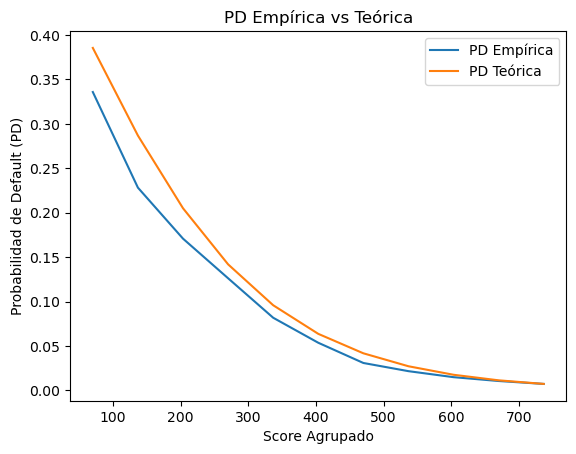

In [32]:
Tasas.plot(title='PD Empírica vs Teórica')
plt.ylabel('Probabilidad de Default (PD)')
plt.xlabel('Score Agrupado')
plt.legend(['PD Empírica', 'PD Teórica'])
plt.show()

### Kolmogorov-Smirnov

In [23]:
Score = pd.pivot_table(data=Escalado,
                       index='Score Agrupado', columns='Clasificación',
                       aggfunc='size')
Score

Clasificación,0,1
Score Agrupado,,
70.002823,86,37
136.656804,55,20
203.310786,157,29
269.964768,70,7
336.618749,362,42
403.272731,532,25
469.926713,504,17
536.580694,1641,48
603.234676,2846,44


In [24]:
Score.columns

Index([0, 1], dtype='int64', name='Clasificación')

In [25]:

TotalB = Score[0].sum()
TotalM = Score[1].sum()

Score['DBuenos'] = Score[0]/TotalB
Score['DMalos'] = Score[1]/TotalM
Score['AcumB'] = Score['DBuenos'].cumsum()
Score['AcumM'] = Score['DMalos'].cumsum()
Score['Delta'] = abs(Score['AcumB'] - Score['AcumM'])

KS = Score['Delta'].max()

print(Score)
print(f'KS máximo: {KS}')

Clasificación      0   1   DBuenos    DMalos     AcumB     AcumM     Delta
Score Agrupado                                                            
70.002823         86  37  0.004776  0.104225  0.004776  0.104225  0.099449
136.656804        55  20  0.003054  0.056338  0.007830  0.160563  0.152733
203.310786       157  29  0.008719  0.081690  0.016549  0.242254  0.225704
269.964768        70   7  0.003887  0.019718  0.020436  0.261972  0.241535
336.618749       362  42  0.020103  0.118310  0.040540  0.380282  0.339742
403.272731       532  25  0.029544  0.070423  0.070084  0.450704  0.380620
469.926713       504  17  0.027989  0.047887  0.098073  0.498592  0.400519
536.580694      1641  48  0.091131  0.135211  0.189204  0.633803  0.444599
603.234676      2846  44  0.158050  0.123944  0.347254  0.757746  0.410493
669.888658      2952  30  0.163936  0.084507  0.511190  0.842254  0.331063
736.542639      8802  56  0.488810  0.157746  1.000000  1.000000  0.000000
KS máximo: 0.444598618534

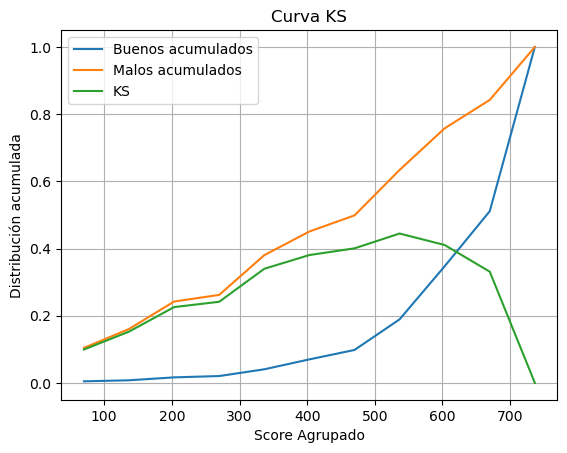

In [26]:
plt.plot(Score.index, Score['AcumB'], label='Buenos acumulados')
plt.plot(Score.index, Score['AcumM'], label='Malos acumulados')
plt.plot(Score.index, Score['Delta'], label='KS')
plt.legend()
plt.title('Curva KS')
plt.xlabel('Score Agrupado')
plt.ylabel('Distribución acumulada')
plt.grid()
plt.show()


KS > 40%: Modelo con muy buena capacidad discriminatoria

El modelo puede distinguir efectivamente entre las dos clases ("buenos" vs "malos")



### Índice de Gini

In [33]:
Gini = pd.DataFrame()
Gini['AcumB'] = Score['AcumB']
Gini['AcumM'] = Score['AcumM']

Gini['Delta B'] = None
Gini['Delta M'] = None

Gini.iloc[0, 2] = Gini.iloc[0, 0]
Gini.iloc[0, 3] = Gini.iloc[0, 1]

for i in range(1, len(Gini)):
    Gini.iloc[i, 2] = Gini.iloc[i, 0] + Gini.iloc[i-1, 0]
    Gini.iloc[i, 3] = Gini.iloc[i, 1] - Gini.iloc[i-1, 1]

Gini['Ag'] = Gini['Delta B'] * Gini['Delta M'] * 0.5
Ag = Gini['Ag'].sum()
IGini = (.5 - Ag)/.5
print(f'Índice de Gini: {IGini}')

Índice de Gini: 0.5567509348868243


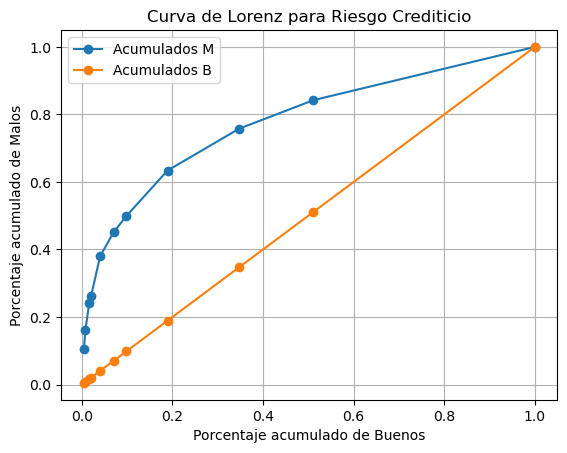

In [28]:
plt.plot(Gini['AcumB'], Gini['AcumM'], marker='o', label='Acumulados M')
plt.plot(Gini['AcumB'], Gini['AcumB'], marker='o', label='Acumulados B')


plt.title('Curva de Lorenz para Riesgo Crediticio')
plt.xlabel('Porcentaje acumulado de Buenos')
plt.ylabel('Porcentaje acumulado de Malos')
plt.legend()
plt.grid(True)
plt.show()

### Information Value

In [29]:
IV = pd.DataFrame()
IV['DBuenos'] = Score['DBuenos']
IV['DMalos'] = Score['DMalos']
IV['WoE'] = np.log(Score['DBuenos'] / Score['DMalos'])
IV['IV'] = (IV['DBuenos'] - IV['DMalos']) * IV['WoE']
InformationV = IV['IV'].sum()
print(f'Information Value: {InformationV}')

Information Value: 1.3238870695031646


### AUROC

$$
AUC = \dfrac{1}{2} * (Índice \ de \ Gini \ + 1)
$$

In [30]:
AUROC = (1/2)*(IGini + 1)
print(f'AUROC: {AUROC}')

AUROC: 0.7783754674434121


El AUROC representa la probabilidad de que el modelo asigne una puntuación más alta a un malo pagador aleatorio que a un bueno pagador aleatorio.

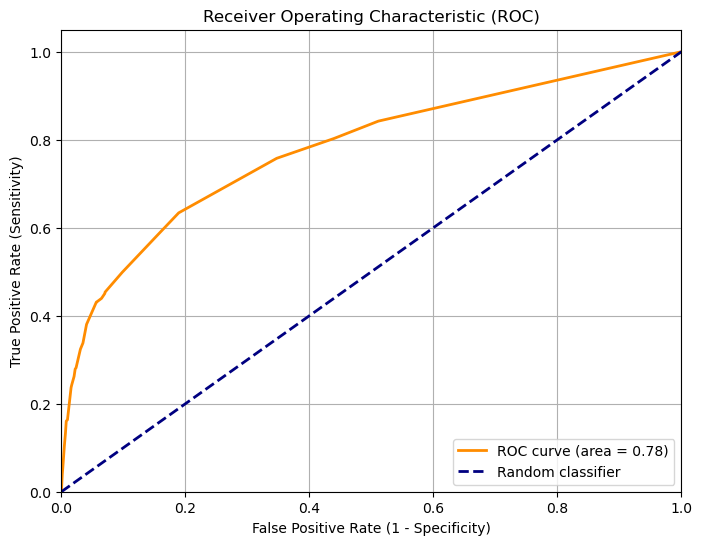

In [31]:
fpr, tpr, thresholds = roc_curve(Escalado['Clasificación'], Escalado['PD'])

roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()